# CAB420, Practical 9 - Question 2 Template
## Multi-Task Learning with Siamese Networks

Siamese networks can also be configured for multi-task learning. There are many ways to do this, but a common way is to consider a secondary task on one of the inputs. Using the Metric Learning (week 7) practical solution as a starting point, add a second task to the network. Possible tasks include:
* A classification output, which uses the embedding from one image (such as the anchor image) to classify the face into the identity using a softmax output.
* An image output, that adds a decoder to the embedding to try and reconstruct the original image.	

For both of these, you may also wish to consider appropriate loss weights. Any selection of loss weights should consider both the importance of the tasks, and also the scale of the losses (i.e. are both losses typically in the same range? Or is one much larger or smaller than the other?).

Using the modified network, evaluate the face recognition performance on YaleB, ORL and Yale. As with Question 1, use a simple classifier and feel free to borrow from code such as the week 7 practical solutions. Compare the generalisation ability of the multi-task network to the original single task network.

### Relevant Examples

The semi-supervised and multi-task examples are of most use here:
* ``CAB420_Encoders_and_Decoders_Example_2_Multiple_Outputs.ipynb``
* ``CAB420_Encoders_and_Decoders_Example_3_Semi_Supervised_Learning.ipynb``

Any of the earlier examples, and in particular prac solutions that have worked with the face rec data are also going to give you some good code to re-use (though a lot of this is already copied below).

### Suggested Packages

It's tensorflow, with our other favourites thrown in (sklearn, matplotlib).

In [1]:
import os
# why is this here? This is disabling some tensorflow warning I get in some of my environments that 
# annoy me (look ugly and untidy really)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

import random
import numpy
import numpy.matlib
import scipy.io
import matplotlib.pyplot as plt

import keras
from keras import layers
from keras.layers import Dense, Conv2D, BatchNormalization, Activation, AveragePooling2D, Input, Flatten
from keras.regularizers import l2

from sklearn import decomposition
from sklearn import discriminant_analysis
from sklearn import datasets
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import ConfusionMatrixDisplay

# for consistency
random.seed(4)

### Step 1: Code Reuse

Code is borrowed from previous examples. In particular:
* The Week 7 practical solution, which used the face rec datasets with a triplet network. The data loading, network structure, face rec classifier training and evaluation is taken from here. Really, we're just adding a second task to this network

#### Data Loading

Load YaleB, reshape into images, and display it. We'll also convert the labels to a categorical here as we want to use those with a classification head.

In [2]:
yale_b = scipy.io.loadmat('YaleB_32x32.mat')
fea = yale_b['fea'] / 255.0
gnd = numpy.array(yale_b['gnd']) - 1

test_frames = numpy.array(()).astype('int')
for i in numpy.unique(gnd):    
    indexes = numpy.where(gnd == i)[0]
    count = len(indexes);
    f = numpy.random.randint(count, size=6)
    test_frames = numpy.append(test_frames, indexes[f])

train_fea = fea
train_gnd = gnd
train_fea = numpy.delete(train_fea, test_frames, 0)
train_gnd = numpy.delete(train_gnd, test_frames, 0)
test_fea = fea[test_frames, :]
test_gnd = gnd[test_frames, :]
train_gnd = numpy.reshape(train_gnd, -1)
test_gnd = numpy.reshape(test_gnd, -1)

train_fea_reshape = numpy.reshape(train_fea.transpose(), (32, 32, 1, len(train_fea)))
train_fea_reshape = numpy.transpose(train_fea_reshape, (3, 1, 0, 2))
test_fea_reshape = numpy.reshape(test_fea.transpose(), (32, 32, 1, len(test_fea)))
test_fea_reshape = numpy.transpose(test_fea_reshape, (3, 1, 0, 2))

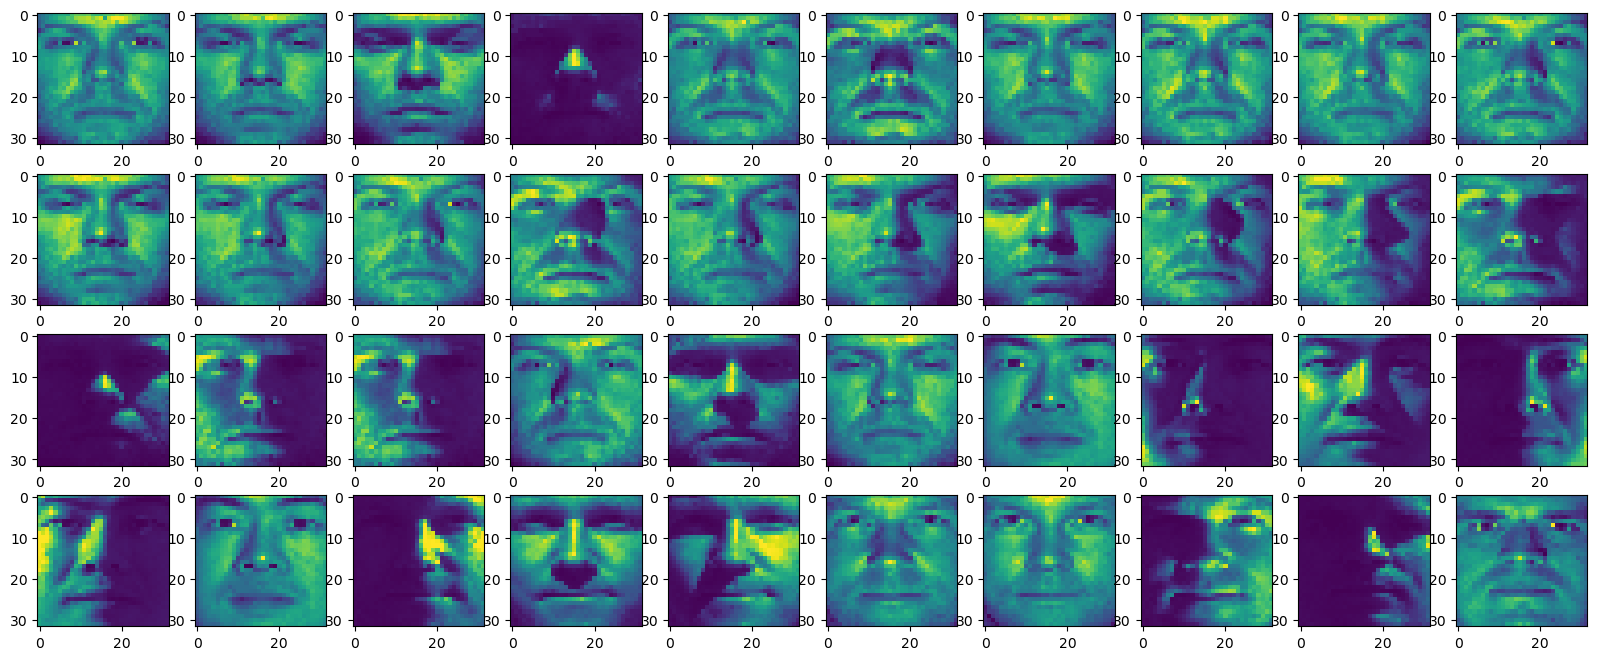

In [3]:
fig = plt.figure(figsize=[20, 8])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 1)
    ax.imshow(train_fea_reshape[i,:,:,0])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 21)
    ax.imshow(test_fea_reshape[i,:,:,0])    

#### Data Extraction Functions

Copy and paste again from the metric learning prac, however we are have made a couple of minor mods:
* GetTripletData will also pull out category labels, so the second task could be a classifier
* GetTripletData_2 will also pull out the anchor image again, so the second task could be an autoencoder

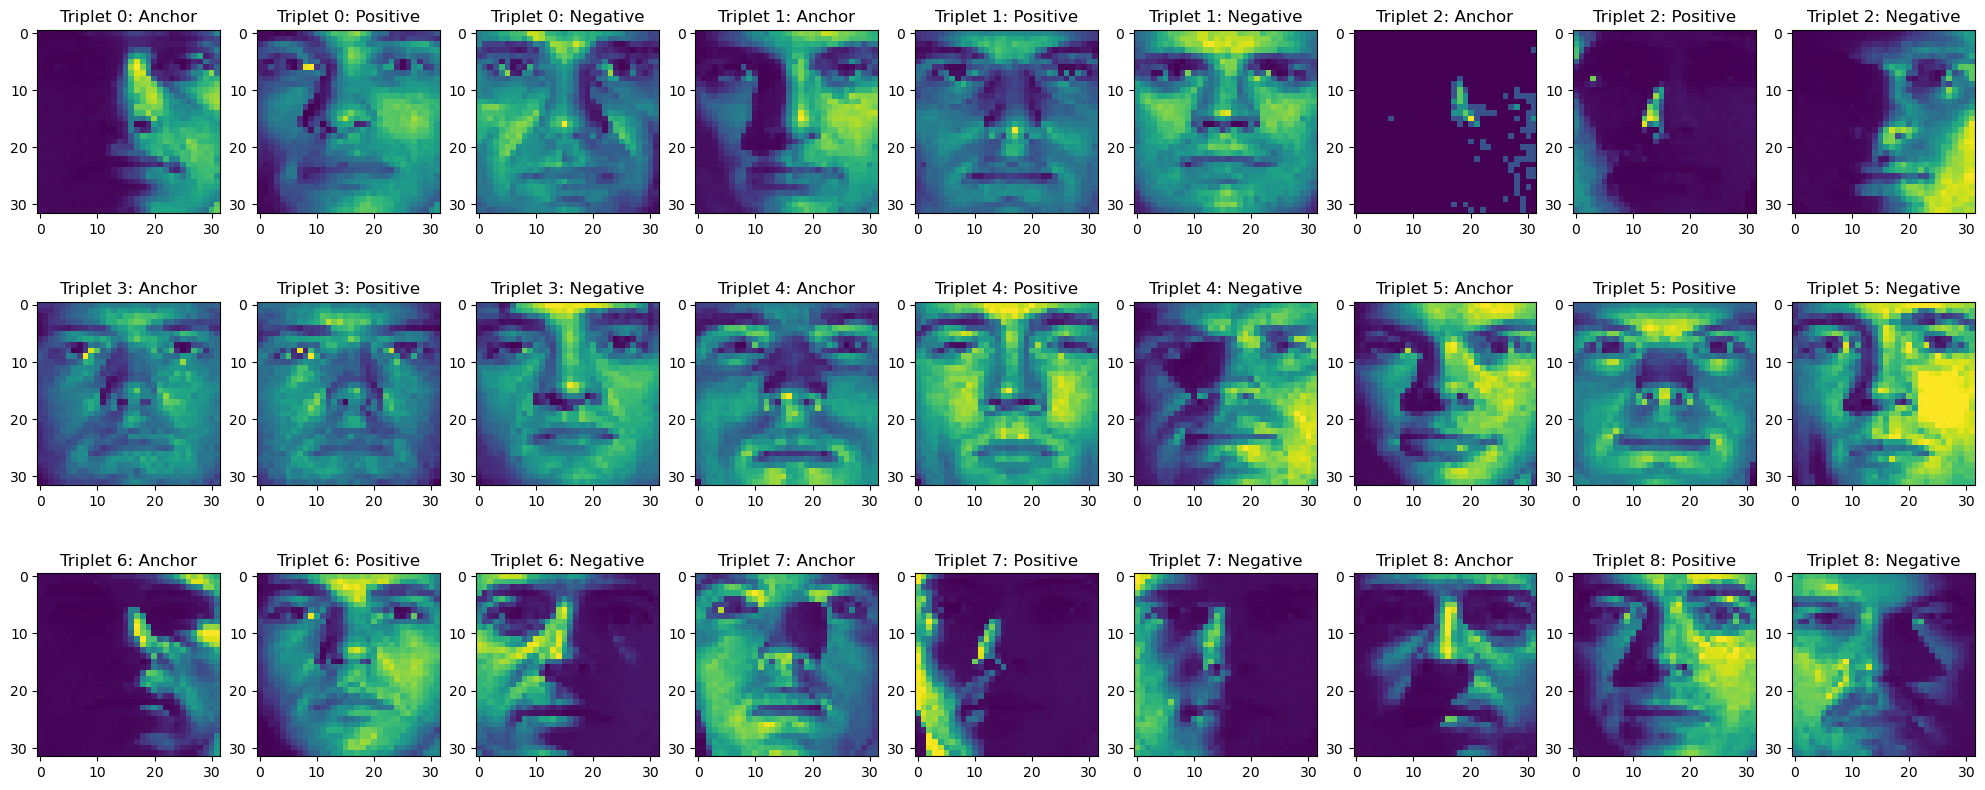

In [4]:
def GetTripletData(imgs, labels, labels_categorical, batch_size):

    image_a = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    image_b = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    image_c = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    out_labels = numpy.zeros((batch_size, numpy.shape(labels_categorical)[1]))
        
    for i in range(batch_size):
        
        idx1 = random.randint(0, len(imgs) - 1)
        out_labels[i, :] = labels_categorical[idx1, :]
        idx2 = random.randint(0, len(imgs) - 1)
        idx3 = random.randint(0, len(imgs) - 1)

        while (labels[idx1] != labels[idx2]):
            idx2 = random.randint(0, len(imgs) - 1)            
                
        while (labels[idx1] == labels[idx3]):
            idx3 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        image_c[i, :, :, :] = imgs[idx3,:,:,:]

    return [image_a, image_b, image_c], out_labels

def GetTripletData_2(imgs, labels, batch_size):

    image_a = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    image_b = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    image_c = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
    out_labels = numpy.zeros((batch_size, numpy.shape(imgs)[1], numpy.shape(imgs)[2], numpy.shape(imgs)[3]));
        
    for i in range(batch_size):
        
        idx1 = random.randint(0, len(imgs) - 1)
        idx2 = random.randint(0, len(imgs) - 1)
        idx3 = random.randint(0, len(imgs) - 1)

        while (labels[idx1] != labels[idx2]):
            idx2 = random.randint(0, len(imgs) - 1)            
                
        while (labels[idx1] == labels[idx3]):
            idx3 = random.randint(0, len(imgs) - 1)

        image_a[i, :, :, :] = imgs[idx1,:,:,:]
        out_labels[i, :, :, :] = imgs[idx1,:,:,:]
        image_b[i, :, :, :] = imgs[idx2,:,:,:]
        image_c[i, :, :, :] = imgs[idx3,:,:,:]

    return [image_a, image_b, image_c], out_labels

x, y = GetTripletData(train_fea_reshape, train_gnd, keras.utils.to_categorical(train_gnd), 9)

fig = plt.figure(figsize=[25, 10])
for i in range(9):
    ax = fig.add_subplot(3, 9, i*3 + 1)
    ax.imshow(x[0][i,:,:,0])
    ax.set_title('Triplet ' + str(i) + ': Anchor')
    
    ax = fig.add_subplot(3, 9, i*3 + 2)
    ax.imshow(x[1][i,:,:,0])    
    ax.set_title('Triplet ' + str(i) + ': Positive')

    ax = fig.add_subplot(3, 9, i*3 + 3)
    ax.imshow(x[2][i,:,:,0])    
    ax.set_title('Triplet ' + str(i) + ': Negative')        

In [5]:
def conv_block(inputs, filters, spatial_dropout = 0.0, max_pool = True):
    
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation='relu')(inputs)
    x = layers.Conv2D(filters=filters, kernel_size=(3,3), padding='same', activation=None)(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (spatial_dropout > 0.0):
        x = layers.SpatialDropout2D(spatial_dropout)(x)
    if (max_pool == True):
        x = layers.MaxPool2D(pool_size=(2, 2))(x)
    
    return x

def fc_block(inputs, size, dropout):
    x = layers.Dense(size, activation=None)(inputs)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)
    if (dropout > 0.0):
        x = layers.Dropout(dropout)(x)
    
    return x

def vgg_net(inputs, filters, fc, spatial_dropout = 0.0, dropout = 0.0):
    
    x = inputs
    for idx,i in enumerate(filters):
        x = conv_block(x, i, spatial_dropout, not (idx==len(filters) - 1))
    
    x = layers.Flatten()(x)
    
    for i in fc:
        x = fc_block(x, i, dropout)
        
    return x

def normalise_vector(vect):
    # get the magnitude for each vector in the batch
    mag = keras.ops.sqrt(keras.ops.sum(keras.ops.square(vect), axis=1))
    # repeat this, so we now have as many elements in mag as we do in vect
    mag = keras.ops.reshape(keras.ops.repeat(mag, vect.shape[1], axis=0), (-1, vect.shape[1]))
    # element wise division
    return keras.ops.divide(vect, mag)

def euclidean_distance(vects):
    x, y = vects
    x = normalise_vector(x) # this is just doing x = tf.math.l2_normalize(x, axis=1)
    y = normalise_vector(y) # this is just doing y = tf.math.l2_normalize(y, axis=1)

    sum_square = keras.ops.sum(keras.ops.square(keras.ops.subtract(x, y)), axis=1, keepdims=True)
    return keras.ops.sqrt(keras.ops.maximum(sum_square, keras.config.epsilon()))

def eucl_dist_output_shape(shapes):
    shape1, shape2 = shapes
    return (shape1[0], 1)

def contrastive_loss(y_true, y_pred):
    '''Contrastive loss from Hadsell-et-al.'06
    http://yann.lecun.com/exdb/publis/pdf/hadsell-chopra-lecun-06.pdf
    '''
    margin = 1
    square_pred = keras.ops.square(y_pred)
    margin_square = keras.ops.square(keras.ops.maximum(margin - y_pred, 0))
    return keras.ops.mean(y_true * square_pred + (1 - y_true) * margin_square)

class TripletLossLayer(layers.Layer):
    def __init__(self, alpha, **kwargs):
        self.alpha = alpha
        super(TripletLossLayer, self).__init__(**kwargs)
    
    def triplet_loss(self, inputs):
        anchor, positive, negative = inputs
        
        anchor = normalise_vector(anchor)
        positive = normalise_vector(positive)
        negative = normalise_vector(negative)

        p_dist = keras.ops.sum(keras.ops.square(anchor-positive), axis=-1)
        n_dist = keras.ops.sum(keras.ops.square(anchor-negative), axis=-1)
        return keras.ops.sum(keras.ops.maximum(p_dist - n_dist + self.alpha, 0), axis=0)
        
    def call(self, inputs):
        loss = self.triplet_loss(inputs)
        self.add_loss(loss)
        return loss

In [6]:
def resnet_layer(inputs,
                 num_filters=16,
                 kernel_size=3,
                 strides=1,
                 activation='relu',
                 batch_normalization=True,
                 conv_first=True):

    conv = Conv2D(num_filters,
                  kernel_size=kernel_size,
                  strides=strides,
                  padding='same',
                  kernel_initializer='he_normal',
                  kernel_regularizer=l2(1e-4))

    x = inputs
    if conv_first:
        x = conv(x)
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
    else:
        if batch_normalization:
            x = BatchNormalization()(x)
        if activation is not None:
            x = Activation(activation)(x)
        x = conv(x)
    return x


def resnet_v1(inputs, filters, num_res_blocks, pool_size):

    x = resnet_layer(inputs=inputs,
                     num_filters=filters[0])

    # Instantiate the stack of residual units
    for stack, filters in enumerate(filters):
        for res_block in range(num_res_blocks):
            strides = 1
            if stack > 0 and res_block == 0:  # first layer but not first stack
                strides = 2  # downsample
            y = resnet_layer(inputs=x,
                             num_filters=filters,
                             strides=strides)
            y = resnet_layer(inputs=y,
                             num_filters=filters,
                             activation=None)
            if stack > 0 and res_block == 0:  # first layer but not first stack
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=filters,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])
            x = Activation('relu')(x)
 
    # Add classifier on top.
    # v1 does not use BN after last shortcut connection-ReLU
    x = AveragePooling2D(pool_size=pool_size)(x)
    y = Flatten()(x)

    return y


def resnet_v2(inputs, filters, num_res_blocks, pool_size):

    x = resnet_layer(inputs=inputs,
                     num_filters=filters[0],
                     conv_first=True)

    # Instantiate the stack of residual units
    for stage, filters in enumerate(filters):
        num_filters_in = filters
        for res_block in range(num_res_blocks):
            activation = 'relu'
            batch_normalization = True
            strides = 1
            if stage == 0:
                num_filters_out = num_filters_in * 4
                if res_block == 0:  # first layer and first stage
                    activation = None
                    batch_normalization = False
            else:
                num_filters_out = num_filters_in * 2
                if res_block == 0:  # first layer but not first stage
                    strides = 2    # downsample

            # bottleneck residual unit
            y = resnet_layer(inputs=x,
                             num_filters=num_filters_in,
                             kernel_size=1,
                             strides=strides,
                             activation=activation,
                             batch_normalization=batch_normalization,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_in,
                             conv_first=False)
            y = resnet_layer(inputs=y,
                             num_filters=num_filters_out,
                             kernel_size=1,
                             conv_first=False)
            if res_block == 0:
                # linear projection residual shortcut connection to match
                # changed dims
                x = resnet_layer(inputs=x,
                                 num_filters=num_filters_out,
                                 kernel_size=1,
                                 strides=strides,
                                 activation=None,
                                 batch_normalization=False)
            x = keras.layers.add([x, y])

        num_filters_in = num_filters_out

    # Add classifier on top.
    # v2 has BN-ReLU before Pooling
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = AveragePooling2D(pool_size=pool_size)(x)
    y = Flatten()(x)
    return y

### Step 2: The Network

Build your network here. I'd suggest you start from a vanilla triplet network, i.e. create the backbone, the three inputs, and the loss function layer. 

Once you've got that sorted, you need to answer the question: *What is your second task?* Whatever the answer to this, I'd suggest that you build a little subnetwork that takes the output of the encoder applied to the anchor, and then does whatever it needs to do to get the desired output (i.e. perform classification, or decode back to the original image, or both, or even something else).

You can then build your network, where you'll have multiple inputs (anchor, positive, negative) and multiple outputs. Remember to specify a loss for each output, and you may wish to consider loss weights as well.

You can then evaluate the network. The evaluation function from the metric learning (week 7) prac is copied below. Depending on how you've approached this, you may want to extend this, or add another function, to look more directly at the second task you've added to the network.

In terms of getting embeddings to train our usual simple face rec CKNN, you can just pass images through the backbone like you normally would.

In [7]:
inputs = keras.layers.Input(shape=(32, 32, 1, ), name='img')
x = resnet_v1(inputs, [16, 32, 64], 2, 7)
output = keras.layers.Dense(32)(x)

backbone = keras.Model(inputs = inputs, outputs = output)
backbone.summary()
backbone.compile(jit_compile = False)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ img (InputLayer)    │ (None, 32, 32, 1) │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 32, 32,    │        160 │ img[0][0]         │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 32, 32,    │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 32, 32,    │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 32, 32,    │      2,320 │ activation_1[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 32, 32,    │          0 │ activation[0][0], │
│                     │ 16)               │            │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ add[0][0]         │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 32, 32,    │      2,320 │ activation_2[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 32, 32,    │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 32, 32,    │      2,320 │ activation_3[0][… │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │         64 │ conv2d_4[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 32, 32,    │          0 │ activation_2[0][… │
│                     │ 16)               │            │ batch_normalizat

 Total params: 177,696 (694.12 KB)

 Trainable params: 176,768 (690.50 KB)

 Non-trainable params: 928 (3.62 KB)

In [8]:
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal"),
  layers.RandomRotation(0.05),
  layers.RandomZoom(0.025),
  layers.RandomTranslation(height_factor=(-0.025, 0.025), width_factor=(-0.025, 0.025))
])

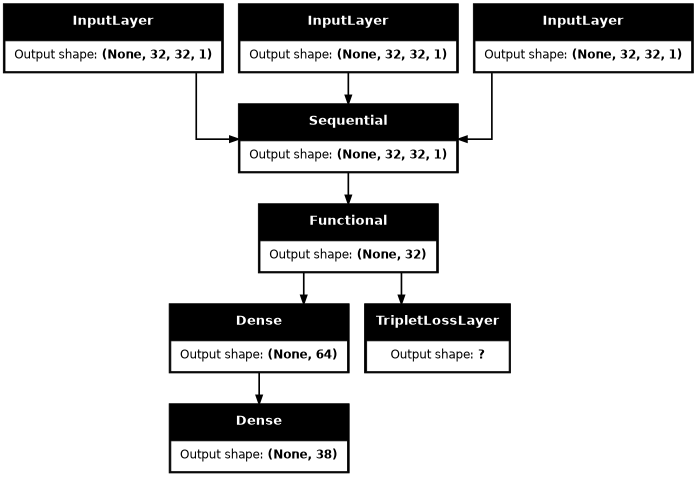

In [9]:
inputs_a = keras.layers.Input(shape=(32, 32, 1, ), name='img_a')
inputs_p = keras.layers.Input(shape=(32, 32, 1, ), name='img_p')
inputs_n = keras.layers.Input(shape=(32, 32, 1, ), name='img_n')

augmented_a = data_augmentation(inputs_a)
augmented_p = data_augmentation(inputs_p)
augmented_n = data_augmentation(inputs_n)

embedding_a = backbone(augmented_a)
embedding_p = backbone(augmented_p)
embedding_n = backbone(augmented_n)

class_output = keras.layers.Dense(64, activation='relu')(embedding_a)
class_output = keras.layers.Dense(38, activation='softmax')(class_output)

margin = 1
loss_layer = TripletLossLayer(alpha=margin, name='triplet_loss_layer')(
    [embedding_a, embedding_p, embedding_n])

triplet_network = keras.Model([inputs_a, inputs_p, inputs_n], [class_output, loss_layer])
keras.utils.plot_model(triplet_network, show_shapes=True, dpi = 60, expand_nested=False)

In [10]:
# note I'm selecting no metrics here, accuracy doesn't make sense for the way that we're training the model
triplet_network.compile(optimizer=keras.optimizers.AdamW(), 
                        loss = [keras.losses.CategoricalCrossentropy(), None], jit_compile=False)

triplet_test_x, triplet_test_y = GetTripletData(test_fea_reshape, test_gnd, keras.utils.to_categorical(train_gnd), 10000)
for i in range(25):
    triplet_train_x, triplet_train_y = GetTripletData(train_fea_reshape, train_gnd, keras.utils.to_categorical(train_gnd), 10000)    
    triplet_network.fit(triplet_train_x, y=triplet_train_y, batch_size = 128, epochs=1, 
                        validation_data = (triplet_test_x, triplet_test_y))

79/79 ━━━━━━━━━━━━━━━━━━━━ 42s 300ms/step - loss: 115.7273 - val_loss: 104.3976
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - loss: 101.4362 - val_loss: 102.6505
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - loss: 94.3644 - val_loss: 121.4610
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - loss: 87.0265 - val_loss: 80.2608
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 181ms/step - loss: 70.3692 - val_loss: 78.2018
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step - loss: 64.5552 - val_loss: 54.6495
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - loss: 53.4151 - val_loss: 59.3250
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - loss: 46.1689 - val_loss: 58.2536
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - loss: 40.2999 - val_loss: 60.7451
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - loss: 38.4146 - val_loss: 69.0679
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - loss: 31.8581 - val_loss: 58.2876
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 178ms/step - loss: 28.4790 - val_loss: 37.9606
79/79 ━━━━━━━━━━━━━━━━━━━━ 14s 179ms/step - loss: 24.7026 -

69/69 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step


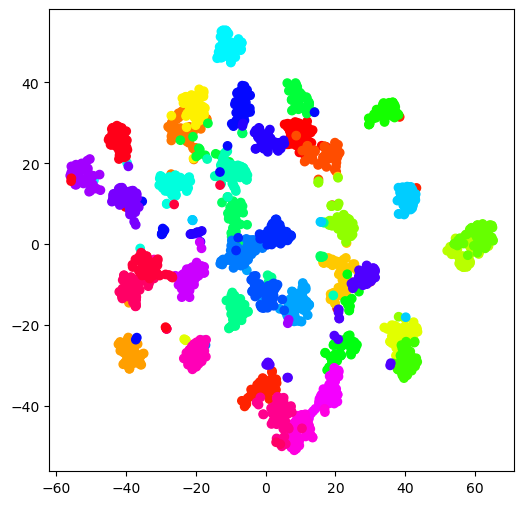

In [11]:
sample_output = backbone.predict(train_fea_reshape)
tsne_embeddings = TSNE(random_state=4).fit_transform(sample_output)
fig = plt.figure(figsize=[6, 6])
ax = fig.add_subplot(1, 1, 1)
ax.scatter(tsne_embeddings[:,0], tsne_embeddings[:,1], c = train_gnd, cmap='hsv');

In [12]:
def eval_model(model, X_train, Y_train, X_test, Y_test):
    fig = plt.figure(figsize=[25, 8])
    ax = fig.add_subplot(1, 2, 1)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_train, Y_train, normalize='true', ax=ax)
    pred = model.predict(X_train)
    conf.ax_.set_title('Training Set Performance: %s' % (sum(pred == Y_train)/len(Y_train)));
    ax = fig.add_subplot(1, 2, 2)
    conf = ConfusionMatrixDisplay.from_estimator(model, X_test, Y_test, normalize='true', ax=ax)
    pred = model.predict(X_test)
    conf.ax_.set_title('Test Set Performance: %s' % (sum(pred == Y_test)/len(Y_test)));    

69/69 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 176ms/step


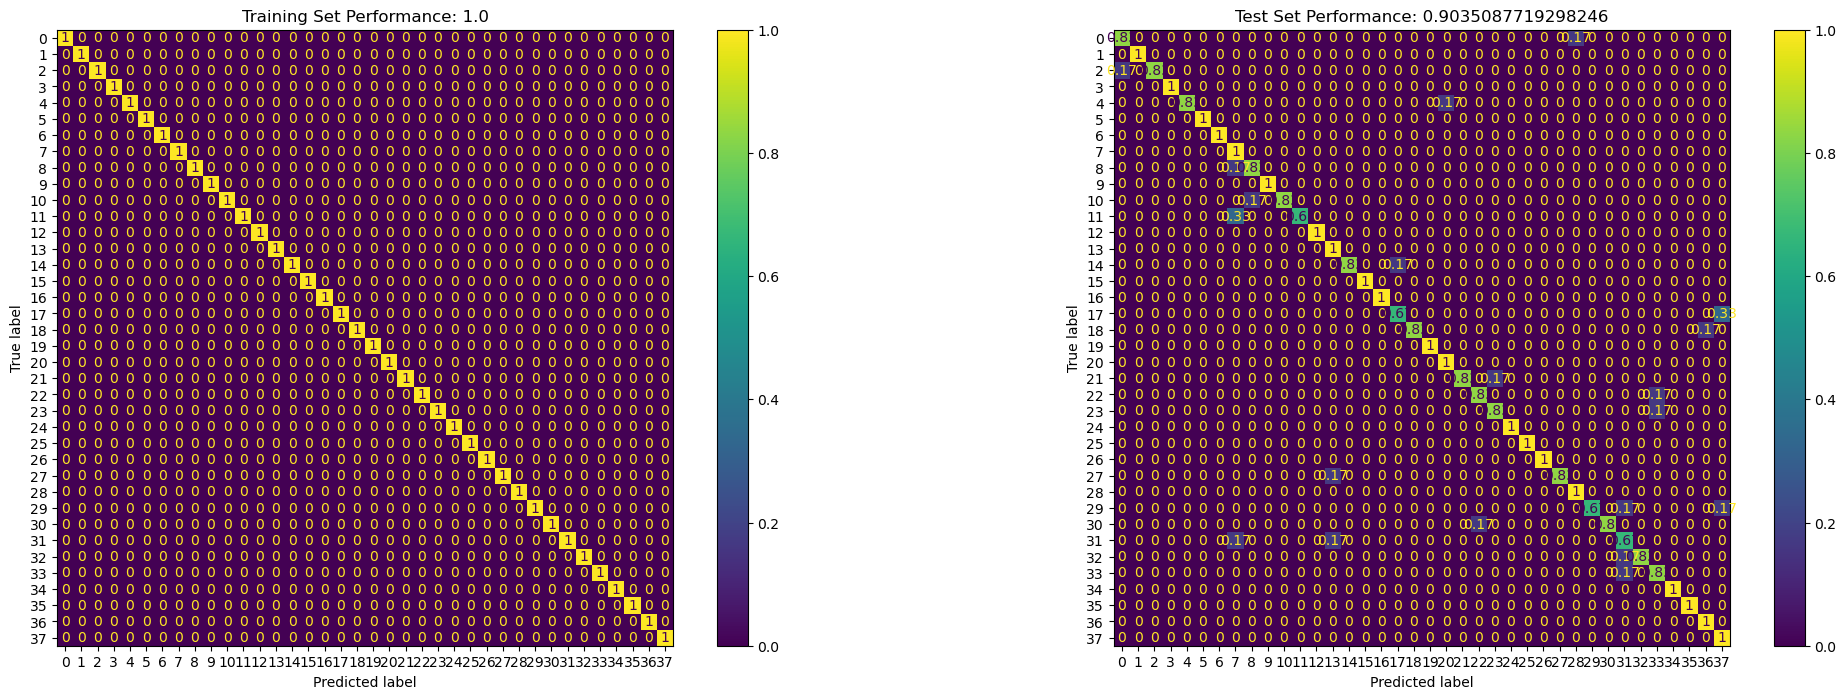

In [13]:
cknn = KNeighborsClassifier(n_neighbors=10, weights='distance')
train_embeddings = backbone.predict(train_fea_reshape)
test_embeddings = backbone.predict(test_fea_reshape)

cknn.fit(train_embeddings, train_gnd)
eval_model(cknn, train_embeddings, train_gnd, test_embeddings, test_gnd)

### Step 3: Generalisation Time

As per usual, it's now time to see if this scales to other datasets. In particular, does the second task help generalisation at all. We have both ORL and Yale here. Code is provided to load the datasets. It's then just a case of you applying the model you developed above to this new data.

#### ORL

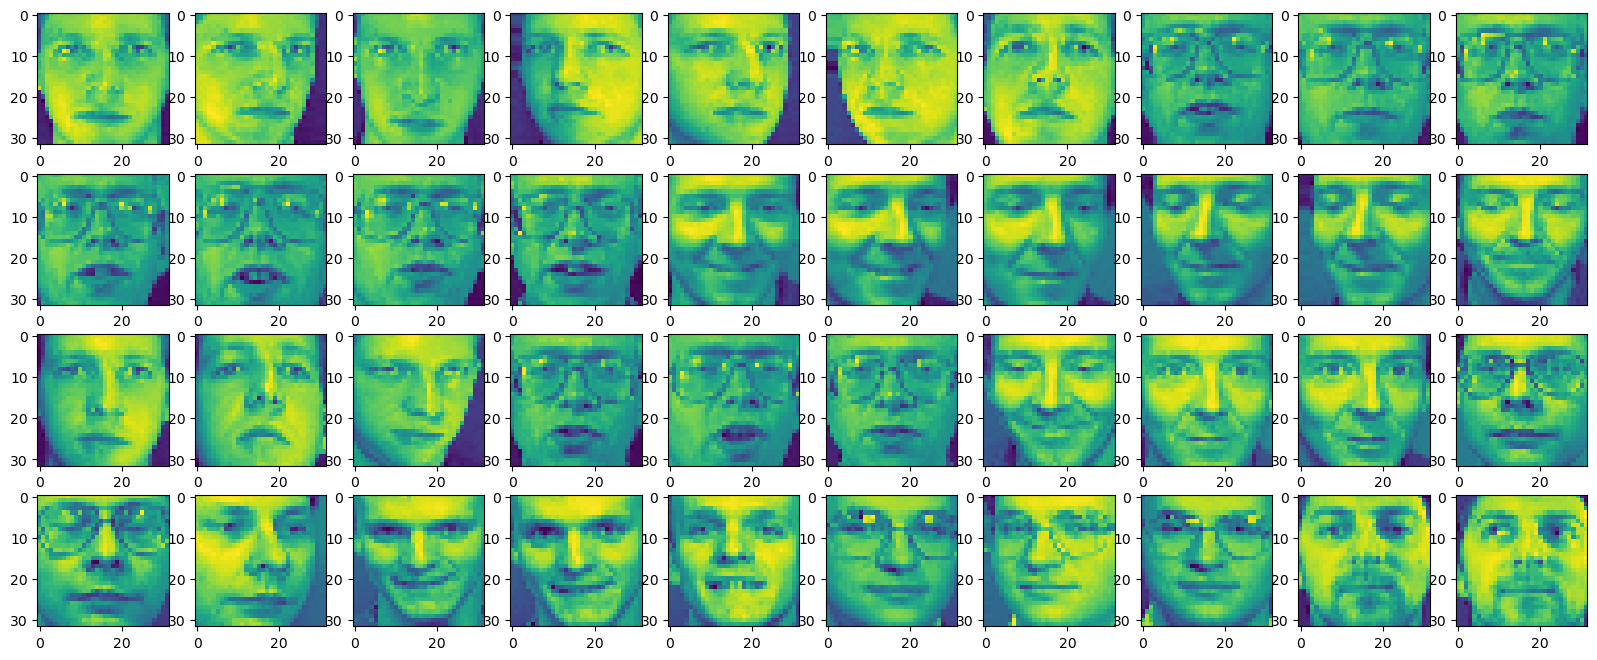

In [14]:
orl = scipy.io.loadmat('ORL_32x32.mat');
fea = orl['fea'] / 255.0
gnd = numpy.array(orl['gnd'])

train_frames = []
for i in range(40):
    for j in range(7):
        train_frames.append(i*10 + j)
        
train_orl_fea = fea[train_frames, :]
train_orl_gnd = gnd[train_frames, :]
test_orl_fea = fea
test_orl_gnd = gnd
test_orl_fea = numpy.delete(test_orl_fea, train_frames, 0)
test_orl_gnd = numpy.delete(test_orl_gnd, train_frames, 0)
train_orl_gnd = numpy.reshape(train_orl_gnd, -1)
test_orl_gnd = numpy.reshape(test_orl_gnd, -1)

train_fea_reshape = numpy.reshape(train_orl_fea.transpose(), (32, 32, 1, len(train_orl_fea)))
train_fea_reshape = numpy.transpose(train_fea_reshape, (3, 1, 0, 2))
test_fea_reshape = numpy.reshape(test_orl_fea.transpose(), (32, 32, 1, len(test_orl_fea)))
test_fea_reshape = numpy.transpose(test_fea_reshape, (3, 1, 0, 2))

fig = plt.figure(figsize=[20, 8])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 1)
    ax.imshow(train_fea_reshape[i,:,:,0])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 21)
    ax.imshow(test_fea_reshape[i,:,:,0])    

9/9 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


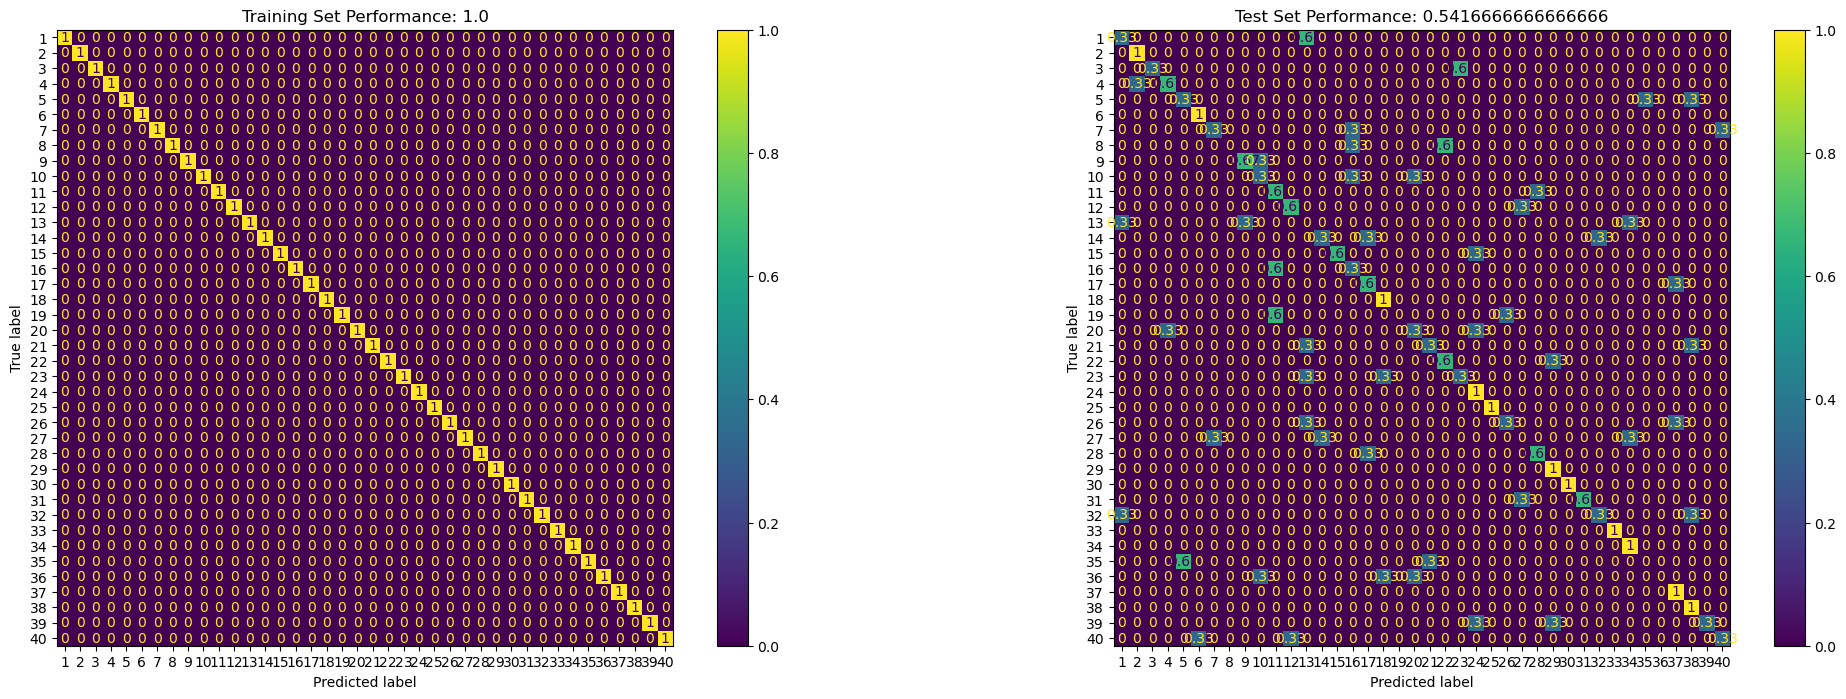

In [15]:
cknn = KNeighborsClassifier(n_neighbors=10, weights='distance')
train_embeddings = backbone.predict(train_fea_reshape)
test_embeddings = backbone.predict(test_fea_reshape)

cknn.fit(train_embeddings, train_orl_gnd)
eval_model(cknn, train_embeddings, train_orl_gnd, test_embeddings, test_orl_gnd)

#### Yale

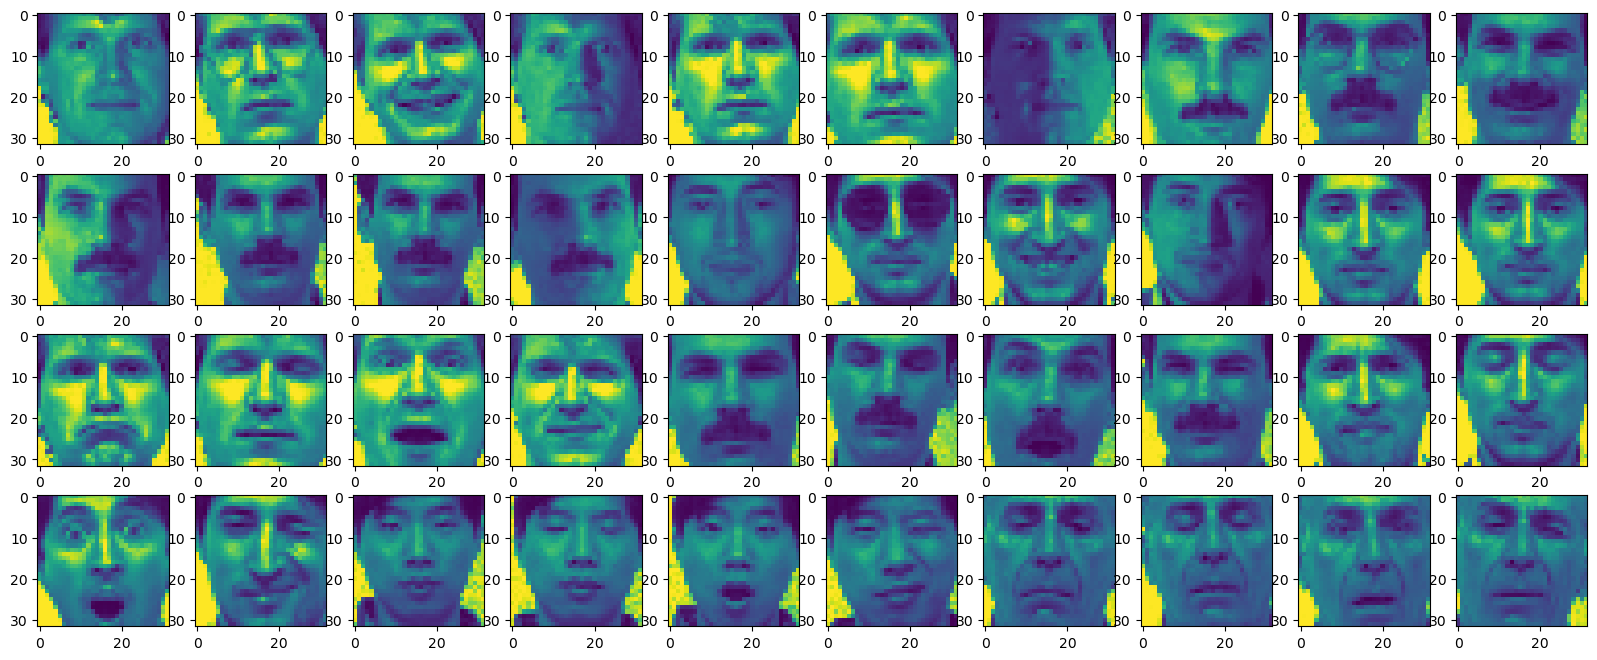

In [16]:
yale = scipy.io.loadmat('Yale_32x32.mat');
fea = yale['fea'] / 255.0
gnd = numpy.array(yale['gnd'])

train_frames = []
for i in range(15):
    for j in range(7):
        train_frames.append(i*11 + j)

train_yale_fea = fea[train_frames, :]
train_yale_gnd = gnd[train_frames, :]
test_yale_fea = fea
test_yale_gnd = gnd
test_yale_fea = numpy.delete(test_yale_fea, train_frames, 0)
test_yale_gnd = numpy.delete(test_yale_gnd, train_frames, 0)
train_yale_gnd = numpy.reshape(train_yale_gnd, -1)
test_yale_gnd = numpy.reshape(test_yale_gnd, -1)

train_fea_reshape = numpy.reshape(train_yale_fea.transpose(), (32, 32, 1, len(train_yale_fea)))
train_fea_reshape = numpy.transpose(train_fea_reshape, (3, 1, 0, 2))
test_fea_reshape = numpy.reshape(test_yale_fea.transpose(), (32, 32, 1, len(test_yale_fea)))
test_fea_reshape = numpy.transpose(test_fea_reshape, (3, 1, 0, 2))

fig = plt.figure(figsize=[20, 8])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 1)
    ax.imshow(train_fea_reshape[i,:,:,0])
for i in range(20):
    ax = fig.add_subplot(4, 10, i + 21)
    ax.imshow(test_fea_reshape[i,:,:,0])   

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 409ms/step
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step 


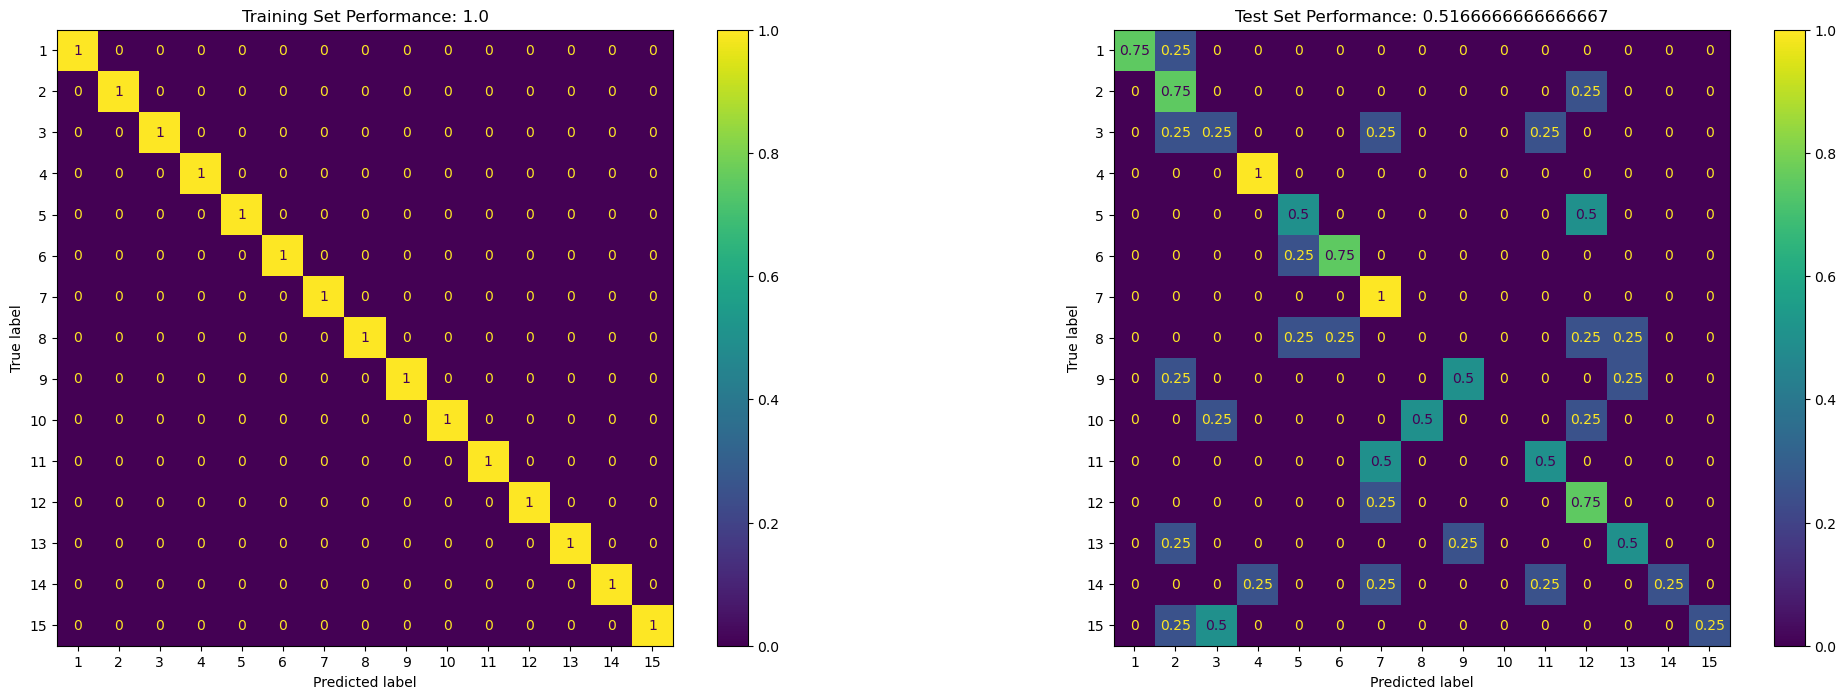

In [17]:
cknn = KNeighborsClassifier(n_neighbors=10, weights='distance')
train_embeddings = backbone.predict(train_fea_reshape)
test_embeddings = backbone.predict(test_fea_reshape)

cknn.fit(train_embeddings, train_yale_gnd)
eval_model(cknn, train_embeddings, train_yale_gnd, test_embeddings, test_yale_gnd)